IMAGE

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

Install Libraries

In [ ]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version 1.7
!pip install timm

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100    14  100    14    0     0     22      0 --:--:-- --:--:-- --:--:--    22
100    14  100    14    0     0     22      0 --:--:-- --:--:-- --:--:--    22
  File "f:\research\chatbot\D\Multi-modal-codes\pytorch-xla-env-setup.py", line 1
    404: Not Found
    ^^^
SyntaxError: illegal target for annotation


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ggplot")

import torch
import torch.nn as nn
import torchvision.transforms as transforms

import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.distributed.parallel_loader as pl

import timm

import gc
import os
import time
import random
from datetime import datetime

from PIL import Image
from tqdm.notebook import tqdm
from sklearn import model_selection, metrics


In [ ]:
# For parallelization in TPUs
os.environ["XLA_USE_BF16"] = "1"
os.environ["XLA_TENSOR_ALLOCATOR_MAXSIZE"] = "100000000"

In [ ]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1001)

hyperparameters

In [ ]:
# model specific global variables
IMG_SIZE = 224
BATCH_SIZE = 16
LR = 2e-05
GAMMA = 0.7
N_EPOCHS = 10

Load Train data

In [ ]:
df = pd.read_csv(os.path.join("/content/gdrive/MyDrive/CRISIS_1-20220401T060043Z-001/CRISIS_1/task_informative_text_img_train.csv"))
df.head()

,event_name,tweet_id,image_id,tweet_text,image,label,label_text,label_image,label_text_image
0,california_wildfires,9.177910e+17,917791291823591425_0,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive
1,california_wildfires,9.177910e+17,917791291823591425_1,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,data_image/california_wildfires/10_10_2017/917...,not_informative,informative,not_informative,Negative
2,california_wildfires,9.177930e+17,917793137925459968_0,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive
3,california_wildfires,9.177930e+17,917793137925459968_1,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive
4,california_wildfires,9.177930e+17,917793137925459968_2,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive


In [ ]:
selected_columns=df[['image','label_image']]
df=selected_columns.copy()

In [ ]:
code = []

for i in range(df.shape[0]):
    if (df.iloc[i]['label_image']=='informative'):
        code.append(1)
    elif (df.iloc[i]['label_image']=='not_informative'):
        code.append(0)
    else:
        poke_type.append('NaN')
        code.append('NaN')
df['label'] = code
df = df

df.reset_index(drop=True, inplace=True)

Encode Label

In [ ]:
df.drop('label_image',axis = 1,inplace=True)

In [ ]:
df

,image,label
0,data_image/california_wildfires/10_10_2017/917...,1
1,data_image/california_wildfires/10_10_2017/917...,0
2,data_image/california_wildfires/10_10_2017/917...,1
3,data_image/california_wildfires/10_10_2017/917...,1
4,data_image/california_wildfires/10_10_2017/917...,1
...,...,...
13603,data_image/hurricane_maria/25_9_2017/912341945...,1
13604,data_image/hurricane_irma/19_9_2017/9099366121...,0
13605,data_image/hurricane_harvey/7_9_2017/905581858...,0
13606,data_image/hurricane_irma/18_9_2017/9098797465...,0


Check Label Count

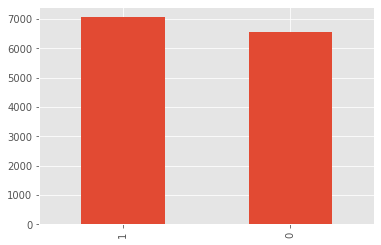

In [ ]:
df.label.value_counts().plot(kind="bar")
lab=df.label.value_counts().plot(kind="bar")

In [ ]:
lab.figure.savefig("labelcount.png")

In [ ]:
train_df=df

In [ ]:
train_df

,image,label
0,data_image/california_wildfires/10_10_2017/917...,1
1,data_image/california_wildfires/10_10_2017/917...,0
2,data_image/california_wildfires/10_10_2017/917...,1
3,data_image/california_wildfires/10_10_2017/917...,1
4,data_image/california_wildfires/10_10_2017/917...,1
...,...,...
13603,data_image/hurricane_maria/25_9_2017/912341945...,1
13604,data_image/hurricane_irma/19_9_2017/9099366121...,0
13605,data_image/hurricane_harvey/7_9_2017/905581858...,0
13606,data_image/hurricane_irma/18_9_2017/9098797465...,0


Load Validation data

In [ ]:
test_df = pd.read_csv(os.path.join("/content/gdrive/MyDrive/CRISIS_1-20220401T060043Z-001/CRISIS_1/task_informative_text_img_dev.csv"))
test_df.head()

,event_name,tweet_id,image_id,tweet_text,image,label,label_text,label_image,label_text_image
0,iraq_iran_earthquake,931465546129989632,931465546129989632_0,#Iran #earthquake damage put at over 5bn pound...,data_image/iraq_iran_earthquake/17_11_2017/931...,not_informative,informative,not_informative,Negative
1,hurricane_harvey,905064623199719425,905064623199719425_0,We've lost track of how many houses/families @...,data_image/hurricane_harvey/5_9_2017/905064623...,informative,informative,informative,Positive
2,hurricane_maria,922857566220283904,922857566220283904_0,The gym above subway got destroyed. The cement...,data_image/hurricane_maria/24_10_2017/92285756...,informative,informative,informative,Positive
3,hurricane_irma,909767231411769344,909767231411769344_0,Famous Captive Orca Fends For Herself In Flori...,data_image/hurricane_irma/18_9_2017/9097672314...,informative,informative,not_informative,Negative
4,california_wildfires,920571592131915777,920571592131915777_0,Californiaâ€™s Sausalito Fire In Marin Capture...,data_image/california_wildfires/18_10_2017/920...,informative,informative,informative,Positive


In [ ]:
selected_columns=test_df[['image','label_image']]
test_df=selected_columns.copy()

In [ ]:
code = []

for i in range(test_df.shape[0]):
    if (test_df.iloc[i]['label_image']=='informative'):
        code.append(1)
    elif (test_df.iloc[i]['label_image']=='not_informative'):
        code.append(0)
    else:
        poke_type.append('NaN')
        code.append('NaN')
test_df['label'] = code
test_df = test_df

test_df.reset_index(drop=True, inplace=True)

In [ ]:
test_df.drop('label_image',axis = 1,inplace=True)

In [ ]:
test_df

,image,label
0,data_image/iraq_iran_earthquake/17_11_2017/931...,0
1,data_image/hurricane_harvey/5_9_2017/905064623...,1
2,data_image/hurricane_maria/24_10_2017/92285756...,1
3,data_image/hurricane_irma/18_9_2017/9097672314...,0
4,data_image/california_wildfires/18_10_2017/920...,1
...,...,...
2232,data_image/hurricane_maria/21_10_2017/92184296...,1
2233,data_image/mexico_earthquake/21_9_2017/9106586...,1
2234,data_image/hurricane_harvey/9_9_2017/906341151...,0
2235,data_image/hurricane_maria/10_11_2017/92882227...,0


In [ ]:
valid_df=test_df

Make dataset for train,test and valid

In [ ]:
class CassavaDataset(torch.utils.data.Dataset):
    """
    Helper Class to create the pytorch dataset
    """
    
    def __init__(self, df, data_path="/content/gdrive/MyDrive", mode="train", transforms=None):
        super().__init__()
        self.df_data = df.values
        self.data_path = data_path
        self.transforms = transforms
        self.mode = mode
        self.data_dir = "data_image-20220401T062436Z-001" if mode == "train" else "data_image-20220401T062436Z-001"

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, index):
        img_name, label = self.df_data[index]
        img_path = os.path.join(self.data_path, self.data_dir, img_name)
        img = Image.open(img_path).convert("RGB")

        if self.transforms is not None:
            image = self.transforms(img)

        return image, label

tranform image into valid format

In [ ]:
# create image augmentations
transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

transforms_valid = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

In [ ]:
print("Available Vision Transformer Models: ")
timm.list_models("vit*")

Available Vision Transformer Models: 


['vit_base_patch8_224',
 'vit_base_patch8_224_in21k',
 'vit_base_patch16_224',
 'vit_base_patch16_224_in21k',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_224_miil_in21k',
 'vit_base_patch16_384',
 'vit_base_patch16_sam_224',
 'vit_base_patch32_224',
 'vit_base_patch32_224_in21k',
 'vit_base_patch32_384',
 'vit_base_patch32_sam_224',
 'vit_base_r26_s32_224',
 'vit_base_r50_s16_224',
 'vit_base_r50_s16_224_in21k',
 'vit_base_r50_s16_384',
 'vit_base_resnet26d_224',
 'vit_base_resnet50_224_in21k',
 'vit_base_resnet50_384',
 'vit_base_resnet50d_224',
 'vit_giant_patch14_224',
 'vit_gigantic_patch14_224',
 'vit_huge_patch14_224',
 'vit_huge_patch14_224_in21k',
 'vit_large_patch16_224',
 'vit_large_patch16_224_in21k',
 'vit_large_patch16_384',
 'vit_large_patch32_224',
 'vit_large_patch32_224_in21k',
 'vit_large_patch32_384',
 'vit_large_r50_s32_224',
 'vit_large_r50_s32_224_in21k',
 'vit_large_r50_s32_384',
 'vit_small_patch16_224',
 'vit_small_patch16_224_in21k',
 'vit_small_patch16_3

Load Vit 16 model

In [ ]:
MODEL_PATH = (
    "/content/gdrive/MyDrive/jx_vit_base_p16_224-80ecf9dd.pth/jx_vit_base_p16_224-80ecf9dd.pth"
)


load drive path

In [ ]:
DATA_PATH = "/content/drive/MyDrive"

create ViT base 16 model

In [ ]:
class ViTBase16(nn.Module):
    def __init__(self, n_classes, pretrained=False):

        super(ViTBase16, self).__init__()

        self.model = timm.create_model("vit_base_patch16_224", pretrained=False)
        if pretrained:
            self.model.load_state_dict(torch.load(MODEL_PATH))

        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):
        x = self.model(x)
        return x

    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        # keep track of training loss
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        ###################
        # train the model #
        ###################
        self.model.train()
        for i, (data, target) in enumerate(train_loader):
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()
            elif device.type == "xla":
                data = data.to(device, dtype=torch.float32)
                target = target.to(device, dtype=torch.int64)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.forward(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Calculate Accuracy
            accuracy = (output.argmax(dim=1) == target).float().mean()
            # update training loss and accuracy
            epoch_loss += loss
            epoch_accuracy += accuracy

            # perform a single optimization step (parameter update)
            if device.type == "xla":
                xm.optimizer_step(optimizer)

                if i % 20 == 0:
                    xm.master_print(f"\tBATCH {i+1}/{len(train_loader)} - LOSS: {loss}")

            else:
                optimizer.step()

        return epoch_loss / len(train_loader), epoch_accuracy / len(train_loader)

    def validate_one_epoch(self, valid_loader, criterion, device):
        # keep track of validation loss
        valid_loss = 0.0
        valid_accuracy = 0.0

        ######################
        # validate the model #
        ######################
        self.model.eval()
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()
            elif device.type == "xla":
                data = data.to(device, dtype=torch.float32)
                target = target.to(device, dtype=torch.int64)

            with torch.no_grad():
                # forward pass: compute predicted outputs by passing inputs to the model
                output = self.model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # Calculate Accuracy
                accuracy = (output.argmax(dim=1) == target).float().mean()
                # update average validation loss and accuracy
                valid_loss += loss
                valid_accuracy += accuracy

        return valid_loss / len(valid_loader), valid_accuracy / len(valid_loader)

Fit data to TPU

In [ ]:
def fit_tpu(
    model, epochs, device, criterion, optimizer, train_loader, valid_loader=None
):

    valid_loss_min = np.Inf  # track change in validation loss
    # global acc
    # keeping track of losses as it happen
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(1, epochs + 1):
        gc.collect()
        para_train_loader = pl.ParallelLoader(train_loader, [device])

        xm.master_print(f"{'='*50}")
        xm.master_print(f"EPOCH {epoch} - TRAINING...")
        train_loss, train_acc = model.train_one_epoch(
            para_train_loader.per_device_loader(device), criterion, optimizer, device
        )
        xm.master_print(
            f"\n\t[TRAIN] EPOCH {epoch} - LOSS: {train_loss}, ACCURACY: {train_acc}\n"
        )
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        gc.collect()

        if valid_loader is not None:
            gc.collect()
            para_valid_loader = pl.ParallelLoader(valid_loader, [device])
            xm.master_print(f"EPOCH {epoch} - VALIDATING...")
            valid_loss, valid_acc = model.validate_one_epoch(
                para_valid_loader.per_device_loader(device), criterion, device
            )
            xm.master_print(f"\t[VALID] LOSS: {valid_loss}, ACCURACY: {valid_acc}\n")
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)
            gc.collect()

            # save model if validation loss has decreased
            if valid_loss <= valid_loss_min and epoch != 1:
                xm.master_print(
                    "Validation loss decreased ({:.4f} --> {:.4f}).  Saving model ...".format(
                        valid_loss_min, valid_loss
                    )
                )
            valid_loss_min = valid_loss

    return {
        "train_loss": train_losses,
        "valid_losses": valid_losses,
        "train_acc": train_accs,
        "valid_acc": valid_accs
    }

In [ ]:
model = ViTBase16(n_classes=2, pretrained=True)

In [ ]:

def _run():
    
    train_dataset = CassavaDataset(train_df, transforms=transforms_train)
    valid_dataset = CassavaDataset(valid_df, transforms=transforms_valid)

    train_sampler = torch.utils.data.distributed.DistributedSampler(
        train_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True,
    )

    valid_sampler = torch.utils.data.distributed.DistributedSampler(
        valid_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=False,
    )

    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        sampler=train_sampler,
        drop_last=True,
        num_workers=8,
    )

    valid_loader = torch.utils.data.DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        sampler=valid_sampler,
        drop_last=True,
        num_workers=8,
    )

    criterion = nn.CrossEntropyLoss()
    #     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device = xm.xla_device()
    model.to(device)

    lr = LR * xm.xrt_world_size()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    xm.master_print(f"INITIALIZING TRAINING ON {xm.xrt_world_size()} TPU CORES")
    start_time = datetime.now()
    xm.master_print(f"Start Time: {start_time}")

    logs = fit_tpu(
        model=model,
        epochs=N_EPOCHS,
        device=device,
        criterion=criterion,
        optimizer=optimizer,
        train_loader=train_loader,
        valid_loader=valid_loader,
    )
   

    xm.master_print(f"Execution time: {datetime.now() - start_time}")

    xm.master_print("Saving Model")
    
    xm.save(
        model.state_dict(), f'model_5e_{datetime.now().strftime("%Y%m%d-%H%M")}.pth'
    )

In [ ]:
# Start training processes
def _mp_fn(rank, flags):
    torch.set_default_tensor_type("torch.FloatTensor")
    a = _run()
    


# _run()
FLAGS = {}
xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=8, start_method="fork")


INITIALIZING TRAINING ON 8 TPU CORES
Start Time: 2022-04-15 12:21:45.687229
EPOCH 1 - TRAINING...
	BATCH 1/106 - LOSS: 0.734375
	BATCH 21/106 - LOSS: 0.40625
	BATCH 41/106 - LOSS: 0.431640625


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


	BATCH 61/106 - LOSS: 0.478515625
	BATCH 81/106 - LOSS: 0.3046875
	BATCH 101/106 - LOSS: 0.54296875

	[TRAIN] EPOCH 1 - LOSS: 0.439453125, ACCURACY: 0.80078125

EPOCH 1 - VALIDATING...
	[VALID] LOSS: 0.388671875, ACCURACY: 0.828125

EPOCH 2 - TRAINING...
	BATCH 1/106 - LOSS: 0.302734375
	BATCH 21/106 - LOSS: 0.2578125
	BATCH 41/106 - LOSS: 0.2314453125


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


	BATCH 61/106 - LOSS: 0.275390625
	BATCH 101/106 - LOSS: 0.60546875

	[TRAIN] EPOCH 2 - LOSS: 0.3828125, ACCURACY: 0.859375

EPOCH 2 - VALIDATING...
	[VALID] LOSS: 0.37109375, ACCURACY: 0.83984375

Validation loss decreased (0.3887 --> 0.3711).  Saving model ...
EPOCH 3 - TRAINING...
	BATCH 1/106 - LOSS: 0.201171875
	BATCH 21/106 - LOSS: 0.3984375
	BATCH 41/106 - LOSS: 0.1904296875


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


	BATCH 61/106 - LOSS: 0.267578125
	BATCH 81/106 - LOSS: 0.365234375
	BATCH 101/106 - LOSS: 0.40625

	[TRAIN] EPOCH 3 - LOSS: 0.326171875, ACCURACY: 0.890625

EPOCH 3 - VALIDATING...
	[VALID] LOSS: 0.3515625, ACCURACY: 0.84375

Validation loss decreased (0.3711 --> 0.3516).  Saving model ...
EPOCH 4 - TRAINING...
	BATCH 1/106 - LOSS: 0.1494140625
	BATCH 21/106 - LOSS: 0.3359375
	BATCH 41/106 - LOSS: 0.125


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


	BATCH 61/106 - LOSS: 0.1611328125
	BATCH 81/106 - LOSS: 0.275390625
	BATCH 101/106 - LOSS: 0.578125

	[TRAIN] EPOCH 4 - LOSS: 0.302734375, ACCURACY: 0.88671875

EPOCH 4 - VALIDATING...
	[VALID] LOSS: 0.369140625, ACCURACY: 0.84375

EPOCH 5 - TRAINING...
	BATCH 1/106 - LOSS: 0.09375
	BATCH 21/106 - LOSS: 0.15625
	BATCH 41/106 - LOSS: 0.12353515625


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


	BATCH 61/106 - LOSS: 0.25390625
	BATCH 81/106 - LOSS: 0.263671875
	BATCH 101/106 - LOSS: 0.376953125

	[TRAIN] EPOCH 5 - LOSS: 0.26953125, ACCURACY: 0.92578125

EPOCH 5 - VALIDATING...
	[VALID] LOSS: 0.357421875, ACCURACY: 0.83984375

Validation loss decreased (0.3691 --> 0.3574).  Saving model ...
EPOCH 6 - TRAINING...
	BATCH 1/106 - LOSS: 0.10107421875
	BATCH 21/106 - LOSS: 0.2119140625
	BATCH 41/106 - LOSS: 0.1337890625


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


	BATCH 61/106 - LOSS: 0.1435546875
	BATCH 81/106 - LOSS: 0.35546875
	BATCH 101/106 - LOSS: 0.341796875

	[TRAIN] EPOCH 6 - LOSS: 0.259765625, ACCURACY: 0.92578125

EPOCH 6 - VALIDATING...
	[VALID] LOSS: 0.3671875, ACCURACY: 0.84375

EPOCH 7 - TRAINING...
	BATCH 1/106 - LOSS: 0.2333984375
	BATCH 21/106 - LOSS: 0.10693359375
	BATCH 41/106 - LOSS: 0.1328125


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


	BATCH 61/106 - LOSS: 0.2109375
	BATCH 81/106 - LOSS: 0.32421875
	BATCH 101/106 - LOSS: 0.1943359375

	[TRAIN] EPOCH 7 - LOSS: 0.232421875, ACCURACY: 0.94921875

EPOCH 7 - VALIDATING...
	[VALID] LOSS: 0.361328125, ACCURACY: 0.859375

Validation loss decreased (0.3672 --> 0.3613).  Saving model ...
EPOCH 8 - TRAINING...
	BATCH 1/106 - LOSS: 0.12158203125
	BATCH 21/106 - LOSS: 0.099609375
	BATCH 41/106 - LOSS: 0.12255859375


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


	BATCH 61/106 - LOSS: 0.16015625
	BATCH 81/106 - LOSS: 0.291015625
	BATCH 101/106 - LOSS: 0.2177734375

	[TRAIN] EPOCH 8 - LOSS: 0.216796875, ACCURACY: 0.9453125

EPOCH 8 - VALIDATING...
	[VALID] LOSS: 0.408203125, ACCURACY: 0.8359375

EPOCH 9 - TRAINING...
	BATCH 1/106 - LOSS: 0.05908203125
	BATCH 21/106 - LOSS: 0.1435546875
	BATCH 41/106 - LOSS: 0.07470703125


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


	BATCH 61/106 - LOSS: 0.10498046875
	BATCH 81/106 - LOSS: 0.212890625
	BATCH 101/106 - LOSS: 0.2734375

	[TRAIN] EPOCH 9 - LOSS: 0.1884765625, ACCURACY: 0.9609375

EPOCH 9 - VALIDATING...
	[VALID] LOSS: 0.447265625, ACCURACY: 0.828125

EPOCH 10 - TRAINING...
	BATCH 1/106 - LOSS: 0.0111083984375
	BATCH 21/106 - LOSS: 0.166015625
	BATCH 41/106 - LOSS: 0.0703125


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


	BATCH 61/106 - LOSS: 0.3515625
	BATCH 81/106 - LOSS: 0.1767578125
	BATCH 101/106 - LOSS: 0.1865234375

	[TRAIN] EPOCH 10 - LOSS: 0.1982421875, ACCURACY: 0.953125

EPOCH 10 - VALIDATING...
	[VALID] LOSS: 0.447265625, ACCURACY: 0.82421875

Validation loss decreased (0.4473 --> 0.4473).  Saving model ...
Execution time: 0:56:09.471984
Saving Model


Load the saved model

In [ ]:
PATH='/content/gdrive/MyDrive/model_5e_20220415-1317.pth'

In [ ]:
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Check model summary

In [ ]:
model

ViTBase16(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (drop1): Dropout(p=0.0, inplace=False)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop2): Dropout(p=0.0, inplace=Fal

Load Test Data

In [ ]:
test_df = pd.read_csv("/content/gdrive/MyDrive/CRISIS_1-20220401T060043Z-001/CRISIS_1/task_informative_text_img_test.csv")
test_df.head()

,event_name,tweet_id,image_id,tweet_text,image,label,label_text,label_image,label_text_image
0,srilanka_floods,878185882431389696,878185882431389696_0,Cristofer CLEMENTE MORA now in 2nd at aguille ...,data_image/srilanka_floods/23_6_2017/878185882...,not_informative,not_informative,not_informative,Positive
1,hurricane_harvey,906258753707790336,906258753707790336_0,RT @THS_College: On our way to Warrior Restora...,data_image/hurricane_harvey/8_9_2017/906258753...,not_informative,informative,not_informative,Negative
2,hurricane_maria,910542719864397824,910542719864397824_0,Hurricane Maria batters Puerto Rico as a Cat 4...,data_image/hurricane_maria/20_9_2017/910542719...,informative,informative,informative,Positive
3,hurricane_harvey,906219963152785408,906219963152785408_0,ZZ Top Donating ‘La Grange’ Download Sales To ...,data_image/hurricane_harvey/8_9_2017/906219963...,informative,informative,not_informative,Negative
4,hurricane_maria,913009824195104768,913009824195104768_0,8am #Maria update: holding steady as a strong ...,data_image/hurricane_maria/27_9_2017/913009824...,informative,informative,informative,Positive


In [ ]:
selected_columns=test_df[['image','label_image']]
test_df=selected_columns.copy()
code = []

for i in range(test_df.shape[0]):
    if (test_df.iloc[i]['label_image']=='informative'):
        code.append(1)
    elif (test_df.iloc[i]['label_image']=='not_informative'):
        code.append(0)
    else:
        poke_type.append('NaN')
        code.append('NaN')
test_df['label'] = code
test_df = test_df

test_df.reset_index(drop=True, inplace=True)
test_df.drop('label_image',axis = 1,inplace=True)


In [ ]:
test_df

,image,label
0,data_image/srilanka_floods/23_6_2017/878185882...,0
1,data_image/hurricane_harvey/8_9_2017/906258753...,0
2,data_image/hurricane_maria/20_9_2017/910542719...,1
3,data_image/hurricane_harvey/8_9_2017/906219963...,0
4,data_image/hurricane_maria/27_9_2017/913009824...,1
...,...,...
2232,data_image/hurricane_irma/19_9_2017/9102396637...,0
2233,data_image/hurricane_irma/17_9_2017/9094682915...,1
2234,data_image/hurricane_harvey/17_9_2017/90944241...,1
2235,data_image/srilanka_floods/27_6_2017/879731058...,0


In [ ]:
transforms_test = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)


In [ ]:
test_dataset=CassavaDataset(
    test_df,
    transforms=transforms_test
)


In [ ]:
from torch.utils.data import Dataset, DataLoader
test_loader =  DataLoader(
        test_dataset,
        batch_size=1,
        num_workers=2,
        shuffle=False,
)
device = xm.xla_device()

In [ ]:
import numpy
predictions=[]
k=[]
test_predict_image=[]
for imgs,target in test_loader:
    imgs = imgs.to(device, dtype=torch.float32)
    with torch.no_grad():
        model=model.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        predicted=predicted.to('cpu')
        predictions.append(predicted)
        test_predict_image.append(outputs.argmax(dim=1).cpu().item())

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
